In [2]:
import aplpy
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.convolution import convolve_fft, Gaussian2DKernel
import math 
from astropy import units as u
from scipy.interpolate import UnivariateSpline
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import sys
from numpy.random import rand,seed
from pylab import *

In [3]:
#LOADING IN DATA FILES
after_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_000_clean14_1_pbcor.fits')
before_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_000.fits')
after_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B1_051_clean14_pbcor.fits')
before_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B1snap_051.fits')
after_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_000_clean14_pbcor.fits')
before_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_000.fits')
after_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/n_dens_pbcor/N_dens_feather10_B10_066_clean14_pbcor.fits')
before_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/N_dens/N_dens_B10snap_066.fits')
noise_B1_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_000_clean14_1_noise_finalfwhm.fits')
noise_B1_051 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B1snap_051_clean14_noise_finalfwhm.fits')
noise_B10_000 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_000_clean14_noise_finalfwhm.fits')
noise_B10_066 = fits.open('/Users/hannahkoziol/Dropbox/Research/flux_trials/flux10_noise_final/flux10_B10snap_066_clean14_noise_finalfwhm.fits')

In [4]:
#SIMULATED OBSERVATIONAL DATA
def simulated_data_retrieval(sim_self):
    sim_self = sim_self[0].data
    column_density_array_after = sim_self
    flat_column_density_array_after = column_density_array_after.flatten()
    return flat_column_density_array_after

In [5]:
#ORIGINAL SIMULATION DATA
def original_data_retrieval(snap_self):
    snap_self = snap_self[0].data * 10
    column_density_array_before = snap_self / (1e4)
    flat_column_density_array_before = column_density_array_before.flatten()
    return flat_column_density_array_before

In [6]:
#HISTOGRAMS FOR SPLINE
def histogram_before_fit(column_density_before, column_density_after):
    fig, ax = plt.subplots()
    plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "Before Observation and Cleaning", color='firebrick', alpha=0.99)
    before_hist = plt.hist(column_density_before, bins=np.logspace(22, 23.5, 30), log=True, color='firebrick', alpha=0.3)
    plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), histtype = 'step', log=True, label = "After Observation and Cleaning", color='cornflowerblue', alpha=0.99)
    after_hist = plt.hist(column_density_after, bins=np.logspace(22, 23.5, 30), log=True, color='cornflowerblue', alpha=0.3)
    ax.set_xscale('log')
    plt.xlabel('$Log_{10}$ Column Density $\#/cm^2$')
    plt.ylabel('$Log_{10} Frequency$')
    plt.legend(loc = 'lower left')
    plt.close()
    
    before_x = before_hist[1]
    before_mid = [(a + b) /2 for a,b in zip(before_x[:-1], before_x[1:])]
    before_y = before_hist[0]
    x_before_x = np.array(before_mid)
    y_before_y = np.array(before_y)

    after_x = after_hist[1]
    after_mid = [(a + b) /2 for a,b in zip(after_x[:-1], after_x[1:])]
    after_y = after_hist[0]
    x_after_x = np.array(after_mid)
    y_after_y = np.array(after_y)
    
    return x_before_x, y_before_y, x_after_x, y_after_y

In [7]:
#COMBINING THESE FUNCTIONS
def histogram_harvesting(before_data, after_data):
    after_data_flat_array = simulated_data_retrieval(after_data)
    before_data_flat_array = original_data_retrieval(before_data)
    return histogram_before_fit(before_data_flat_array, after_data_flat_array)

In [8]:
#SPLINE FITTING ROUTINE
def spline_method(x_data, y_data):
    spl = UnivariateSpline(x_data, np.log(y_data), k = 1, s = .03)
    x_num_array = np.linspace(min(x_data), max(x_data), 500)
    deriv = spl.derivative(1)

    plt.plot(x_data, y_data, label = 'Data' )
    plt.plot(x_num_array, np.exp(spl(x_num_array)), label = 'Fit', linestyle = ':', color = 'red')
    plt.legend()
    plt.show()
    
    plt.plot(x_num_array, deriv(x_num_array), label = '1st Derivative')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
    max_deriv = deriv(x_num_array)[1]
    x_min_value = x_num_array[np.argwhere(deriv(x_num_array) < max_deriv)][0]
    
    
    return x_min_value

In [138]:
#CREATING PLOTS OF DATA
def create_histogram(image_data, number_of_bins):
    image = np.log10(image_data)
    n_min = np.min(image)
    n_max = np.max(image)
    n_bins = number_of_bins
    n_total = np.count_nonzero(image)
    n_edges = np.linspace(n_min, n_max, n_bins)
    n_cens = [(a + b) /2 for a,b in zip(n_edges[:-1], n_edges[1:])]
    
    bin_width = n_edges[2] - n_edges[1]
    
    x_arr = np.array(n_cens)
    y_arr = np.zeros(n_bins)
    for i in range(n_bins -1):
        pix_in_bin_i = np.where((image>n_edges[i]) & (image<n_edges[i+1]))[0]
        y_arr[i] = np.array(np.count_nonzero(pix_in_bin_i) * ((n_total)**(-1)) * ((bin_width)**(-1)))
        
    normalization = y_arr * bin_width
    normalization_check = np.sum(normalization)
        
    return x_arr, y_arr, normalization_check

In [139]:
create_histogram(data_array[(data_array > x_min_before)], 30)

(array([22.66297273, 22.68926395, 22.71555517, 22.74184639, 22.76813761,
        22.79442883, 22.82072005, 22.84701127, 22.87330249, 22.89959371,
        22.92588493, 22.95217615, 22.97846737, 23.00475859, 23.03104981,
        23.05734103, 23.08363225, 23.10992347, 23.13621469, 23.16250591,
        23.18879713, 23.21508835, 23.24137957, 23.26767079, 23.29396201,
        23.32025323, 23.34654445, 23.37283567, 23.39912689]),
 array([5.49488059e+00, 5.41543208e+00, 4.57106072e+00, 3.81907135e+00,
        3.28879874e+00, 2.82688880e+00, 2.32433079e+00, 2.06935651e+00,
        1.86796378e+00, 1.39312037e+00, 1.12521260e+00, 9.73706144e-01,
        7.55684654e-01, 6.50369189e-01, 5.00710370e-01, 3.10403477e-01,
        2.21716769e-01, 1.77373415e-01, 1.07163105e-01, 5.54291922e-02,
        2.58669564e-02, 2.77145961e-02, 1.84763974e-02, 1.84763974e-03,
        1.84763974e-03, 1.84763974e-03, 1.84763974e-03, 0.00000000e+00,
        1.84763974e-03, 0.00000000e+00]),
 0.9998542698921594)

In [23]:
def plotting_histogram(image_data, number_of_bins):
    x_arr = create_histogram(image_data, number_of_bins)[0]
    y_arr = np.log10(create_histogram(image_data, number_of_bins)[1])
    plt.scatter(x_arr, y_arr[:-1])
    return x_arr, y_arr

In [16]:
before = before_B1_000
after = after_B1_000
noise = noise_B1_000
title = 'B1 000'

x_before_x = histogram_harvesting(before, after)[0]
y_before_y = histogram_harvesting(before, after)[1]
x_after_x = histogram_harvesting(before, after)[2]
y_after_y = histogram_harvesting(before, after)[3]

In [12]:
print(y_before_y)

[1.220e+02 2.420e+02 4.490e+02 1.022e+03 1.832e+03 2.933e+03 4.150e+03
 5.126e+03 5.813e+03 6.614e+03 6.664e+03 6.391e+03 6.037e+03 5.400e+03
 3.880e+03 2.898e+03 2.152e+03 1.450e+03 9.780e+02 6.720e+02 3.260e+02
 1.790e+02 6.300e+01 2.300e+01 6.000e+00 2.000e+00 2.000e+00 1.000e+00
 0.000e+00]


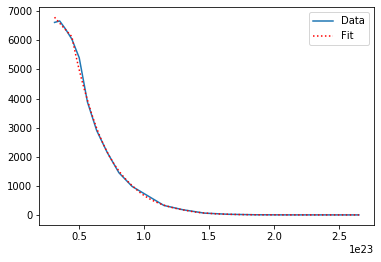

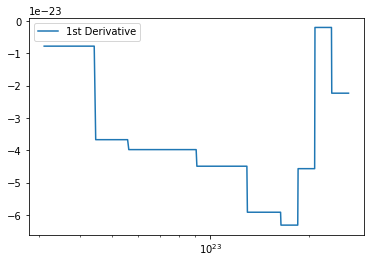

4.464995515365419e+22


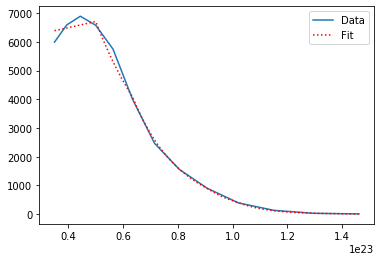

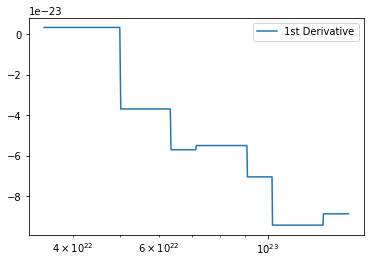

5.012229612489177e+22


In [13]:
x_min_before = spline_method(x_before_x[9:-1], y_before_y[9:-1])[0]
print(x_min_before)

x_min_after = spline_method(x_after_x[10:-6], y_after_y[10:-6])[0]
print(x_min_after)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


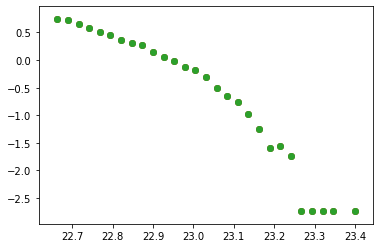

In [133]:
data_array = original_data_retrieval(before_B1_000)
plotting_histogram(data_array[(data_array > x_min_before)], 30)
x_arr = plotting_histogram(data_array[(data_array > x_min_before)], 30)[0]
y_arr = plotting_histogram(data_array[(data_array > x_min_before)], 30)[1]

In [122]:
#FITTING FUNCTION SIMILAR TO OLD METHOD USING SPILKER EQ 5 AND 6
def resid_log(avec, x, y, b):
    A, sigma, mu, alpha, beta = avec
    R = np.zeros_like(x)
    cond1 = np.where(x<b)
    cond2 = np.where(x>b)
    R[cond1] = ((A)/((sigma)*np.sqrt(2*np.pi)*np.exp(x[cond1])))*np.exp((-(x[cond1]-mu)**2)/(2*sigma**2)) - y[cond1]
    R[cond2] = (alpha*x) + beta - y[cond2]
    return R

In [114]:
#FITTING FUNCTION USING ONLY SPILKER EQ 6
def resid_log_powerlaw(avec, x, y):
    alpha, beta = avec
    R = np.zeros_like(x)
    R = (alpha*x) + beta - y
    return R

In [135]:
#MAKING PARAMETER GUESSES AND RUNNING FUNCTION
alpha, beta = -2, 10
afit, flag = optimize.leastsq(resid_log_powerlaw, [alpha, beta], args = (x_arr[:-2], y_arr[:-3]))
print(flag)
print(afit)

1
[ -5.33480631 122.14300861]


In [136]:
def fit_powerlaw(afit, x):
    yfit = np.zeros_like(x)
    yfit = (afit[0]*x) + afit[1]
    return yfit

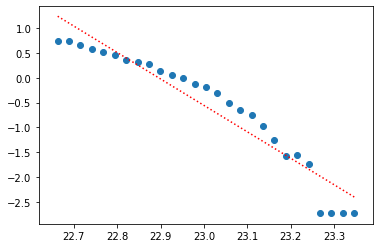

In [137]:
fig, ax = plt.subplots()
ax.scatter(x_arr[:-2], y_arr[:-3])
ax.plot(x_arr[:-2], (fit_powerlaw(afit, x_arr[:-2])), color = 'red', linestyle = ':')
plt.show()